In [9]:
# Mounting your Google Drive is optional, and you could also simply copy and
# upload the data to your colab instance. This manula upload is also easy to do, 
# but you will have to figure out how to do it.
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [10]:
import os
if not os.path.exists("/content/gdrive/My Drive/Colab Notebooks/CS_543_MP4"):
    os.makedirs("/content/gdrive/My Drive/Colab Notebooks/CS_543_MP4")
os.chdir("/content/gdrive/My Drive/Colab Notebooks/CS_543_MP4")

In [11]:
# download dataset
!wget https://drive.switch.ch/index.php/s/UG0ZlZXY47LKSaW/download
!unzip download
!rm download
%cd data
!unzip -qqo albertville_rgb.zip
!unzip -qqo albertville_normal.zip
!unzip -qqo albertville_principal_curvature.zip
!unzip -qqo almena_rgb.zip
!unzip -qqo almena_normal.zip
!unzip -qqo almena_principal_curvature.zip
!rm albertville_rgb.zip albertville_normal.zip albertville_principal_curvature.zip almena_rgb.zip almena_normal.zip almena_principal_curvature.zip
%cd ..

--2021-04-27 03:44:38--  https://drive.switch.ch/index.php/s/UG0ZlZXY47LKSaW/download
Resolving drive.switch.ch (drive.switch.ch)... 86.119.34.138, 86.119.34.137, 2001:620:5ca1:1ee::11, ...
Connecting to drive.switch.ch (drive.switch.ch)|86.119.34.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘download’

download                [  <=>               ] 387.57M  29.3MB/s    in 14s     

2021-04-27 03:44:52 (27.9 MB/s) - ‘download’ saved [406396331]

Archive:  download
 extracting: data/albertville_normal.zip  
 extracting: data/albertville_principal_curvature.zip  
 extracting: data/albertville_rgb.zip  
 extracting: data/almena_normal.zip  
 extracting: data/almena_principal_curvature.zip  
 extracting: data/almena_rgb.zip     
/content/gdrive/My Drive/Colab Notebooks/CS_543_MP4/data
/content/gdrive/My Drive/Colab Notebooks/CS_543_MP4


In [12]:
import glob
import os
import numpy as np
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import cv2
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision import models
from torchvision.transforms import ToTensor, Normalize

In [13]:
# global variable
device = torch.device("cuda:0")

In [14]:
class NormalDataset(data.Dataset):
    """
    Data loader for the Suface Normal Dataset. If data loading is a bottleneck, 
    you may want to optimize this in for faster training. Possibilities include
    pre-loading all images and annotations into memory before training, so as 
    to limit delays due to disk reads.
    """
    def __init__(self, split="train", data_dir="./data"):
        assert(split in ["train", "val"])
        split2name = {
            "train": "almena",
            "val": "albertville",
        }
        self.img_dir = os.path.join(data_dir, split2name[split] + "_rgb", "rgb")
        self.gt_dir = os.path.join(data_dir, split2name[split] + "_normal", "normal")
        
        self.split = split
        self.filenames = [
            os.path.splitext(os.path.basename(l))[0] for l in glob.glob(self.img_dir + "/*.png")
        ]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]
        img = Image.open(os.path.join(self.img_dir, filename) + ".png")
        img = np.asarray(img).copy()
        gt = Image.open(os.path.join(self.gt_dir, filename.replace("_rgb", "_normal")) + ".png")
        gt = np.asarray(gt)

        # from rgb image to surface normal
        gt = gt.astype(np.float32) / 255
        gt = torch.Tensor(np.asarray(gt).copy()).permute((2, 0, 1))
        mask = self.build_mask(gt).to(torch.float)

        img = ToTensor()(img)
        img = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)

        # normalize gt
        gt = gt * 2 - 1
        
        return img.contiguous(), gt, mask.sum(dim=0) > 0

    @staticmethod
    def build_mask(target, val=0.502, tol=1e-3):
        target = target.unsqueeze(0)
        if target.shape[1] == 1:
            mask = ((target >= val - tol) & (target <= val + tol))
            mask = F.conv2d(mask.float(), torch.ones(1, 1, 5, 5, device=mask.device), padding=2) != 0
            return (~mask).expand_as(target).squeeze(0)

        mask1 = (target[:, 0, :, :] >= val - tol) & (target[:, 0, :, :] <= val + tol)
        mask2 = (target[:, 1, :, :] >= val - tol) & (target[:, 1, :, :] <= val + tol)
        mask3 = (target[:, 2, :, :] >= val - tol) & (target[:, 2, :, :] <= val + tol)
        mask = (mask1 & mask2 & mask3).unsqueeze(1)
        mask = F.conv2d(mask.float(), torch.ones(1, 1, 5, 5, device=mask.device), padding=2) != 0
        return (~mask).expand_as(target).squeeze(0)

In [15]:
#additional block 
def angle_error(prediction, target):
    prediction_error = torch.cosine_similarity(prediction, target)
    prediction_error = torch.clamp(prediction_error, min=-1.0, max=1.0)
    prediction_error = torch.acos(prediction_error) * 180.0 / np.pi
    return prediction_error

def simple_predict(split, model):
    model.eval()
    dataset = NormalDataset(split=split)
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)
    gts, preds, losses = [], [], []
    total_normal_errors = None
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, gt, mask = batch
            img = img.to(device)
            gt = gt.to(device)
            mask = mask.to(device)

            pred = model(img)
            loss = (F.l1_loss(pred, gt, reduction="none") * mask).mean()

            gts.append((gt[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            losses.append(loss.item())

            angle_error_prediction = angle_error(pred, gt)
            angle_error_prediction = angle_error_prediction[mask > 0].view(-1)
            if total_normal_errors is None:
                total_normal_errors = angle_error_prediction.cpu().numpy()
            else:
                total_normal_errors = np.concatenate(
                    (total_normal_errors, angle_error_prediction.cpu().numpy())
                )

    return gts, preds, losses, total_normal_errors

class VisualizationDataset(data.Dataset):
    def __init__(self, image_dir="./data/normal_visualization/image", image_ext=".png"):
        self.img_dir = image_dir
        self.img_ext = image_ext
        
        self.image_filenames = [
            os.path.splitext(os.path.basename(l))[0] for l in glob.glob(self.img_dir + "/*" + image_ext)
        ]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        filename = self.image_filenames[index]
        img = Image.open(os.path.join(self.img_dir, filename) + self.img_ext)
        img = np.asarray(img).copy()
        img = ToTensor()(img)
        img = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
        
        return img.contiguous(), filename

def simple_vis(model):
    model.eval()
    dataset = VisualizationDataset(image_dir="./data/normal_visualization/images")
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)
    imgs, preds = [], []

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, _ = batch
            img = img.to(device)

            pred = model(img)
            imgs.append(
                std * img[0].permute((1, 2, 0)).cpu().numpy() + mean
            )
            preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)

    return imgs, preds

from PIL import Image

def simple_test(model, out_dir):
    model.eval()
    dataset = VisualizationDataset(image_dir="./data/Q2_test_data")
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, filename = batch
            img = img.to(device)

            pred = model(img)
            pred = ((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2) * 255
            pred = pred.astype(np.uint8)

            output = os.path.join(out_dir, filename[0] + ".png")

            Image.fromarray(pred).save(output)

#additional block 

In [35]:
##########
#TODO: design your own network here. The expectation is to write from scratch. But it's okay to get some inspiration 
#from conference paper. The bottom line is that you will not just copy code from other repo
##########

class MyModel(nn.Module):

    def __init__(self): # feel free to modify input paramters
        super(MyModel, self).__init__()
        # pass
        #part 2
        # res18 = models.resnet18(pretrained=True)  
        # self.layers = list(res18.children())[:-2]
        # self.layers.append(torch.nn.Conv2d(512,256,1,stride = 1, padding = 0))
        # self.layers.append(torch.nn.BatchNorm2d(256))
        # self.layers.append(torch.nn.ReLU(inplace=True))
        # self.layers.append(torch.nn.Conv2d(256,128,1,stride = 1, padding = 0))
        # self.layers.append(torch.nn.BatchNorm2d(128))
        # self.layers.append(torch.nn.ReLU(inplace=True))
        # self.layers.append(torch.nn.Conv2d(128,64,1,stride = 1, padding = 0))
        # self.layers.append(torch.nn.BatchNorm2d(64))
        # self.layers.append(torch.nn.ReLU(inplace=True))
        # self.layers.append(torch.nn.Conv2d(64,3,1,stride = 1, padding = 0))
        # self.layers.append(torch.nn.Upsample((512,512), mode = 'bilinear'))
        # self.layers = torch.nn.ModuleList(self.layers)

        #part3
        # res18 = models.resnet18(pretrained=True)  
        # self.layers = list(res18.children())[:-2]
        # self.conv0 = torch.nn.Conv2d(512,256,1,stride = 1, padding = 0)
        # self.upsample0 = torch.nn.Upsample(scale_factor=2, mode = 'bilinear')
        # self.conv1 = torch.nn.Conv2d(256,128,1,stride = 1, padding = 0)
        # self.upsample1 = torch.nn.Upsample(scale_factor=2, mode = 'bilinear')
        # self.conv2 = torch.nn.Conv2d(128,64,1,stride = 1, padding = 0)
        # self.upsample2 = torch.nn.Upsample(scale_factor=2, mode = 'bilinear')
        # self.conv3 = torch.nn.Conv2d(64,3,1,stride = 1, padding = 0)
        # self.upsample3 = torch.nn.Upsample(scale_factor=4, mode = 'bilinear')


        # res18 = models.resnet18(pretrained=True)  
        # self.layers = list(res18.children())[:-2]
        # self.layers.append(torch.nn.Conv2d(512,256,1,stride = 1, padding = 0))
        # self.layers.append(torch.nn.BatchNorm2d(256))
        # self.layers.append(torch.nn.Upsample(scale_factor=2, mode = 'bilinear'))
        # self.layers.append(torch.nn.ReLU(inplace=True))
        # self.layers.append(torch.nn.Conv2d(256,128,1,stride = 1, padding = 0))
        # self.layers.append(torch.nn.BatchNorm2d(128))
        # self.layers.append(torch.nn.Upsample(scale_factor=2, mode = 'bilinear'))
        # self.layers.append(torch.nn.ReLU(inplace=True))
        # self.layers.append(torch.nn.Conv2d(128,64,1,stride = 1, padding = 0))
        # self.layers.append(torch.nn.BatchNorm2d(64))
        # self.layers.append(torch.nn.Upsample(scale_factor=2, mode = 'bilinear'))
        # self.layers.append(torch.nn.ReLU(inplace=True))
        # self.layers.append(torch.nn.BatchNorm2d(64))
        # self.layers.append(torch.nn.Conv2d(64,32,1,stride = 1, padding = 0))
        # self.layers.append(torch.nn.BatchNorm2d(32))
        # self.layers.append(torch.nn.Upsample(scale_factor=2, mode = 'bilinear'))
        # self.layers.append(torch.nn.ReLU(inplace=True))
        # # self.layers.append(torch.nn.MaxPool2d(2, 2))
        # self.layers.append(torch.nn.Conv2d(32,16,1,stride = 1, padding = 0))
        # self.layers.append(torch.nn.ReLU(inplace=True))
        # self.layers.append(torch.nn.Conv2d(16,3,1,stride = 1, padding = 0))
        
        # self.layers.append(torch.nn.Upsample(scale_factor=2, mode = 'bilinear'))
        # self.layers = torch.nn.ModuleList(self.layers)

        res18 = models.resnet18(pretrained=True)  
        self.layers = list(res18.children())[:-2]

        self.conv512 = torch.nn.Conv2d(512,512,1,stride = 1, padding = 0)
        self.conv256 = torch.nn.Conv2d(256,256,1,stride = 1, padding = 0)
        self.conv128 = torch.nn.Conv2d(128,128,1,stride = 1, padding = 0)
        self.conv64 = torch.nn.Conv2d(64,64,1,stride = 1, padding = 0)
        self.conv32 = torch.nn.Conv2d(32,32,1,stride = 1, padding = 0)
        self.conv16 = torch.nn.Conv2d(16,16,1,stride = 1, padding = 0)


        self.conv0 = torch.nn.Conv2d(512,256,1,stride = 1, padding = 0)
        self.conv1 = torch.nn.Conv2d(256,128,1,stride = 1, padding = 0)
        self.conv2 = torch.nn.Conv2d(128,64,1,stride = 1, padding = 0)
        self.conv3 = torch.nn.Conv2d(64,32,1,stride = 1, padding = 0)
        self.conv4 = torch.nn.Conv2d(32,3,1,stride = 1, padding = 0)
        # self.conv5 = torch.nn.Conv2d(16,3,1,stride = 1, padding = 0)

        self.bn0 = torch.nn.BatchNorm2d(256)
        self.bn1 = torch.nn.BatchNorm2d(128)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.bn3 = torch.nn.BatchNorm2d(32)
 


        self.upsample = torch.nn.Upsample(scale_factor=2, mode = 'bilinear')
        self.layers = torch.nn.ModuleList(self.layers)
        # self.relu = torch.nn.ReLU(inplace=True)
 

    def forward(self, x): #*params): # feel free to modify input paramters
      #part2
        # for l in self.layers:
        #   x = l(x)
        
        # return x

        # for l in self.layers:
        #   x = l(x)
 
        # tempx = F.relu(self.conv512(x))
        # tempx = F.relu(self.conv0(tempx))  
        # x = F.relu(self.conv0(x))
        # x = torch.cat([x, tempx], dim=1)
        # x = F.relu(self.conv0(x))
        # x = self.upsample(x)


        # tempx = F.relu(self.conv256(x))
        # tempx = F.relu(self.conv1(tempx))  
        # x = F.relu(self.conv1(x))
        # x = torch.cat([x, tempx], dim=1)
        # x = F.relu(self.conv1(x))
        # x = self.upsample(x)



        # tempx = F.relu(self.conv128(x))
        # tempx = F.relu(self.conv2(tempx))  
        # x = F.relu(self.conv2(x))
        # x = torch.cat([x, tempx], dim=1)
        # x = F.relu(self.conv2(x))
        # x = self.upsample(x)



        # tempx = F.relu(self.conv64(x))
        # tempx = F.relu(self.conv3(tempx))  
        # x = F.relu(self.conv3(x))
        # x = torch.cat([x, tempx], dim=1)
        # x = F.relu(self.conv3(x))
        # x = self.upsample(x)



        # tempx = self.conv4(tempx) 
        # x = F.relu(self.conv4(x))
        # x = torch.cat([x, tempx], dim=1)
        # x = self.conv4(x)
        # x = self.upsample(x)

        # x = F.relu(self.conv5(x))

#################
        # tempx = self.conv512(x)
        # tempx = self.conv0(tempx)  #512-256
        # x = self.conv0(x)
        # x = torch.cat([x, tempx], dim=1)
        # x = self.conv0(x)
        # x = self.upsample(x)


        # tempx = self.conv256(x)
        # tempx = self.conv1(tempx)  #512-256
        # x = self.conv1(x)
        # x = torch.cat([x, tempx], dim=1)
        # x = self.conv1(x)
        # x = self.upsample(x)



        # tempx = self.conv128(x)
        # tempx = self.conv2(tempx)  #512-256
        # x = self.conv2(x)
        # x = torch.cat([x, tempx], dim=1)
        # x = self.conv2(x)
        # x = self.upsample(x)



        # tempx = self.conv64(x)
        # tempx = self.conv3(tempx) #512-256
        # x = self.conv3(x)
        # x = torch.cat([x, tempx], dim=1)
        # x = self.conv3(x)
        # x = self.upsample(x)



        # # tempx = self.conv4(tempx)  #512-256
        # # x = self.conv4(x)
        # # x = torch.cat([x, tempx], dim=1)
        # # x = self.conv4(x)
        # x = self.upsample(x)

        # x = self.conv4(x)

        for l in self.layers:
          x = l(x)
 
        tempx = self.conv512(x) 
        tempx = self.conv0(tempx)  #512-256
        x = self.conv0(x)
        x = torch.cat([x, tempx], dim=1)
        x = self.conv0(x)
        x = F.relu(x)
        x = self.bn0(x)
        x = self.upsample(x)




        tempx = self.conv256(x) 
        tempx = self.conv1(tempx)  #512-256
        x = self.conv1(x)
        x = torch.cat([x, tempx], dim=1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.upsample(x)



        tempx = self.conv128(x) 
        tempx = self.conv2(tempx)  #512-256
        x = self.conv2(x)
        x = torch.cat([x, tempx], dim=1)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.upsample(x)



        tempx = self.conv64(x) 
        tempx = self.conv3(tempx)  #512-256
        x = self.conv3(x)
        x = torch.cat([x, tempx], dim=1)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.upsample(x)



        # tempx = self.conv32(x) 
        # tempx = self.conv4(tempx)  #512-256
        x = self.conv4(x)
        x = F.relu(x)
        # x = torch.cat([x, tempx], dim=1)
        # x = self.conv4(x)
        x = self.upsample(x)


        return x



print(MyModel())


MyModel(
  (conv512): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
  (conv256): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
  (conv128): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv64): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv32): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv16): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
  (conv0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  (bn0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-

In [17]:
##########
#TODO: define your loss function here
##########
# import torch.optim as optim
# criterion = nn.CrossEntropyLoss()

class MyCriterion(nn.Module):
    def __init__(self):
        super(MyCriterion, self).__init__()
        pass

    def forward(self, prediction, target, mask):
      # loss = (F.l1_loss(prediction, target, reduction = "none") * mask).sum()
      loss = (F.l1_loss(prediction, target, reduction = "none") * mask).nansum()/512/512
      # print(loss)
      return loss



In [18]:
def simple_train(model, criterion, optimizer, train_dataloader, epoch,**kwargs):
    model.train()
    # TODO: implement your train loop here
    avg_loss = 0.0
    i = 0
    for img,label, mask in train_dataloader:
        img = img.cuda()
        label = label.cuda()
        mask = mask.cuda()
        mask = mask.reshape((mask.shape[0], 1, mask.shape[1], mask.shape[2]))
        mask = torch.cat((mask,mask,mask),axis = 1)
        optimizer.zero_grad()
        pred = model(img)
        loss = criterion(pred, label, mask)
        # print("loss is ", loss)
        i+=1
        avg_loss += loss #/512/512
        loss.backward()
        optimizer.step()
    print("loss in epoch", epoch, "is", avg_loss/i)





In [ ]:
########################################################################
# TODO: Implement your training cycles, make sure you evaluate on validation 
# dataset and compute evaluation metrics every so often. 
# You may also want to save models that perform well.
import torch.optim as optim
model = MyModel().cuda() #to(device)
criterion = MyCriterion().cuda() #.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0)

train_dataset = NormalDataset(split='train')
train_dataloader = data.DataLoader(train_dataset, batch_size=8, 
                                    shuffle=True, num_workers=2, 
                                    drop_last=True)

num_epochs = 130
IS_GPU = True

# model = model.cuda()
min_avg = 35
for epoch in range(num_epochs):
    simple_train(model, criterion, optimizer, train_dataloader, epoch)
    # consider reducing learning rate
    if epoch > 10 and epoch % 10 == 0:
      updated = False
      val_gts, val_preds, val_losses, val_total_normal_errors = simple_predict('val', model)
      print("Validation loss (L1):", np.mean(val_losses))
      print("Validation metrics: Mean %.1f, Median %.1f, 11.25deg %.1f, 22.5deg %.1f, 30deg %.1f" % (
          np.average(val_total_normal_errors), np.median(val_total_normal_errors),
          np.sum(val_total_normal_errors < 11.25) / val_total_normal_errors.shape[0] * 100,
          np.sum(val_total_normal_errors < 22.5) / val_total_normal_errors.shape[0] * 100,
          np.sum(val_total_normal_errors < 30) / val_total_normal_errors.shape[0] * 100
      ))

      # vis validation
      fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
      for idx, ax_i in enumerate(axs.T):
          ax = ax_i[0]
          ax.imshow(val_gts[idx])
          ax.axis('off')
          ax = ax_i[1]
          ax.imshow(val_preds[idx])
          ax.axis('off')
      fig.tight_layout()
      plt.savefig('vis_valset.pdf', format='pdf', bbox_inches='tight')
      #check if updated 
      if  np.average(val_total_normal_errors) < min_avg:
             min_avg = np.average(val_total_normal_errors)
             updated = True

      if updated:
        print("updated with min_abg = ", min_avg)
        #visual
        imgs, preds = simple_vis(model)
        fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
        for idx, ax_i in enumerate(axs.T):

            ax = ax_i[0]
            ax.imshow(imgs[idx])
            ax.axis('off')
            ax = ax_i[1]
            ax.imshow(preds[idx])
            ax.axis('off')
        fig.tight_layout()
        plt.savefig('q2_visualization.pdf', format='pdf', bbox_inches='tight')
        #200 pictures

        out_dir = "Q2_normal_predictions"
        os.makedirs(out_dir, exist_ok=True)
        simple_test(model, out_dir)

print("final min_avg is" , min_avg)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


loss in epoch 0 is tensor(10.5230, device='cuda:0', grad_fn=<DivBackward0>)
loss in epoch 1 is tensor(9.9923, device='cuda:0', grad_fn=<DivBackward0>)
loss in epoch 2 is tensor(9.9217, device='cuda:0', grad_fn=<DivBackward0>)
loss in epoch 3 is tensor(9.8619, device='cuda:0', grad_fn=<DivBackward0>)
loss in epoch 4 is tensor(9.7840, device='cuda:0', grad_fn=<DivBackward0>)
loss in epoch 5 is tensor(9.7670, device='cuda:0', grad_fn=<DivBackward0>)
loss in epoch 6 is tensor(9.7352, device='cuda:0', grad_fn=<DivBackward0>)
loss in epoch 7 is tensor(9.6794, device='cuda:0', grad_fn=<DivBackward0>)
loss in epoch 8 is tensor(9.6440, device='cuda:0', grad_fn=<DivBackward0>)
loss in epoch 9 is tensor(9.6145, device='cuda:0', grad_fn=<DivBackward0>)
loss in epoch 10 is tensor(9.5852, device='cuda:0', grad_fn=<DivBackward0>)
loss in epoch 11 is tensor(9.5954, device='cuda:0', grad_fn=<DivBackward0>)
loss in epoch 12 is tensor(9.6127, device='cuda:0', grad_fn=<DivBackward0>)
loss in epoch 13 is t

# You do not need to change anything below

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)



Validation loss (L1): 0.2620856749196338


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Validation metrics: Mean 36.2, Median 32.4, 11.25deg 11.7, 22.5deg 33.0, 30deg 46.1


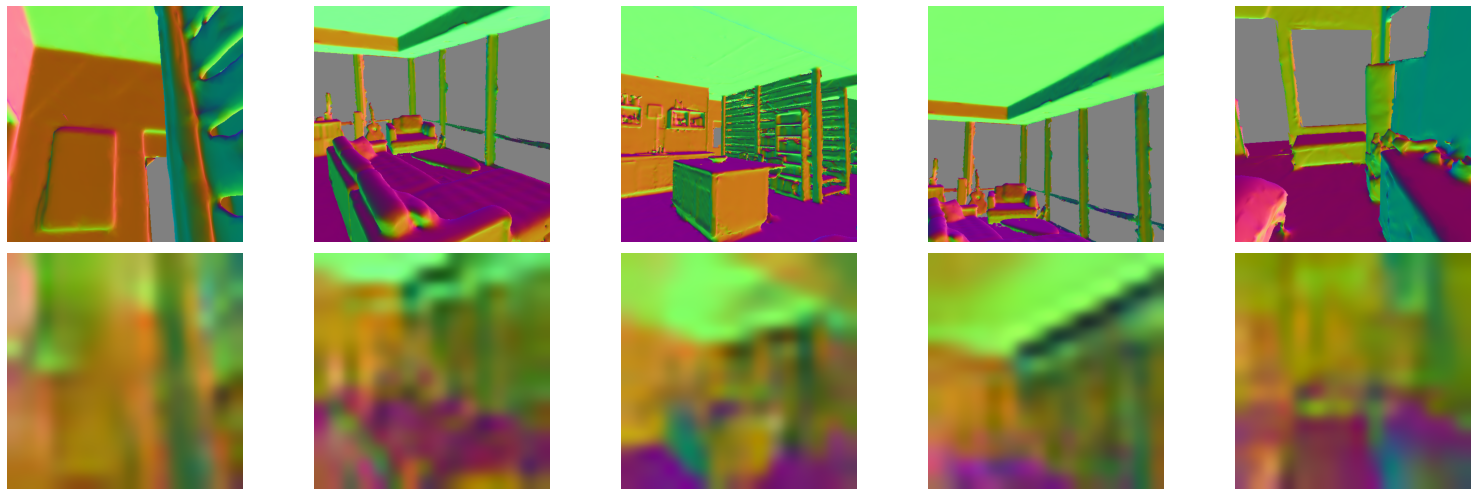

In [28]:
########################################################################
# Evaluate your result, and report
# 1. Mean angular error
# 2. Median angular error
# 3. Accuracy at 11.25 degree
# 4. Accuracy at 22.5 degree
# 5. Accuracy at 30 degree
# using provided `simple_predict` function.

def angle_error(prediction, target):
    prediction_error = torch.cosine_similarity(prediction, target)
    prediction_error = torch.clamp(prediction_error, min=-1.0, max=1.0)
    prediction_error = torch.acos(prediction_error) * 180.0 / np.pi
    return prediction_error

def simple_predict(split, model):
    model.eval()
    dataset = NormalDataset(split=split)
    dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                 num_workers=2, drop_last=False)
    gts, preds, losses = [], [], []
    total_normal_errors = None
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            img, gt, mask = batch
            img = img.to(device)
            gt = gt.to(device)
            mask = mask.to(device)

            pred = model(img)
            loss = (F.l1_loss(pred, gt, reduction="none") * mask).mean()

            gts.append((gt[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)
            losses.append(loss.item())

            angle_error_prediction = angle_error(pred, gt)
            angle_error_prediction = angle_error_prediction[mask > 0].view(-1)
            if total_normal_errors is None:
                total_normal_errors = angle_error_prediction.cpu().numpy()
            else:
                total_normal_errors = np.concatenate(
                    (total_normal_errors, angle_error_prediction.cpu().numpy())
                )

    return gts, preds, losses, total_normal_errors

val_gts, val_preds, val_losses, val_total_normal_errors = simple_predict('val', model)
print("Validation loss (L1):", np.mean(val_losses))
print("Validation metrics: Mean %.1f, Median %.1f, 11.25deg %.1f, 22.5deg %.1f, 30deg %.1f" % (
    np.average(val_total_normal_errors), np.median(val_total_normal_errors),
    np.sum(val_total_normal_errors < 11.25) / val_total_normal_errors.shape[0] * 100,
    np.sum(val_total_normal_errors < 22.5) / val_total_normal_errors.shape[0] * 100,
    np.sum(val_total_normal_errors < 30) / val_total_normal_errors.shape[0] * 100
))

# vis validation
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
for idx, ax_i in enumerate(axs.T):
    ax = ax_i[0]
    ax.imshow(val_gts[idx])
    ax.axis('off')
    ax = ax_i[1]
    ax.imshow(val_preds[idx])
    ax.axis('off')
fig.tight_layout()
plt.savefig('vis_valset.pdf', format='pdf', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


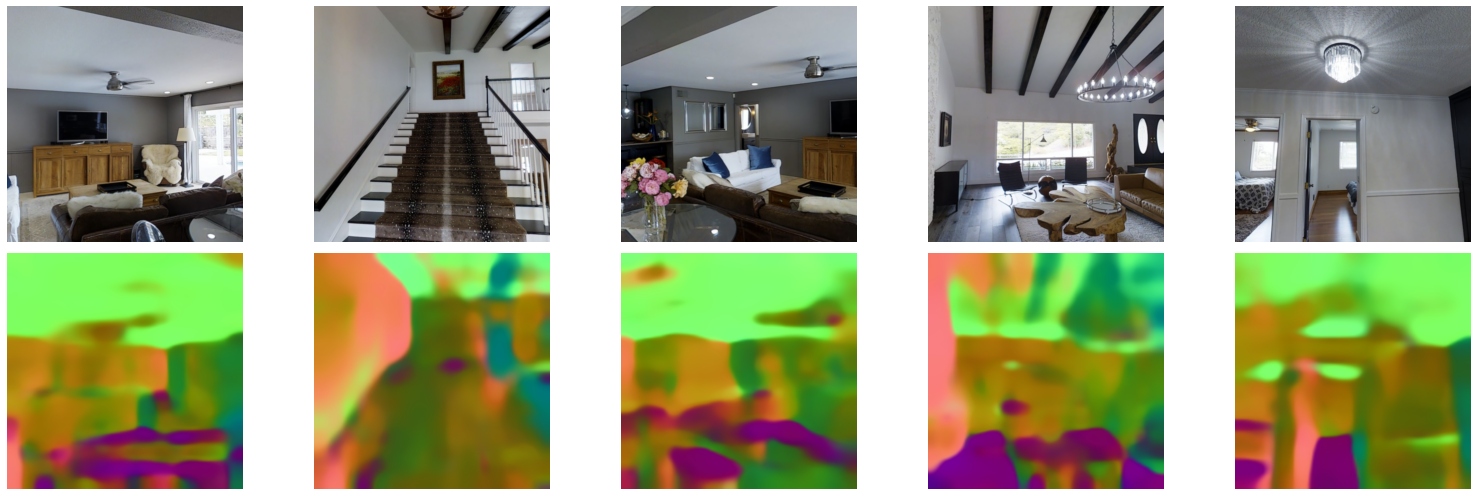

In [ ]:
# # Visualization
# # pick some of your favorite images and put them under `./data/normal_visualization/image`

# class VisualizationDataset(data.Dataset):
#     def __init__(self, image_dir="./data/normal_visualization/image", image_ext=".png"):
#         self.img_dir = image_dir
#         self.img_ext = image_ext
        
#         self.image_filenames = [
#             os.path.splitext(os.path.basename(l))[0] for l in glob.glob(self.img_dir + "/*" + image_ext)
#         ]

#     def __len__(self):
#         return len(self.image_filenames)

#     def __getitem__(self, index):
#         filename = self.image_filenames[index]
#         img = Image.open(os.path.join(self.img_dir, filename) + self.img_ext)
#         img = np.asarray(img).copy()
#         img = ToTensor()(img)
#         img = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
        
#         return img.contiguous(), filename

# def simple_vis(model):
#     model.eval()
#     dataset = VisualizationDataset(image_dir="./data/normal_visualization/images")
#     dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
#                                  num_workers=2, drop_last=False)
#     imgs, preds = [], []

#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])

#     with torch.no_grad():
#         for i, batch in enumerate(tqdm(dataloader)):
#             img, _ = batch
#             img = img.to(device)

#             pred = model(img)
#             imgs.append(
#                 std * img[0].permute((1, 2, 0)).cpu().numpy() + mean
#             )
#             preds.append((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2)

#     return imgs, preds

# imgs, preds = simple_vis(model)
# fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(22, 7))
# for idx, ax_i in enumerate(axs.T):

#     ax = ax_i[0]
#     ax.imshow(imgs[idx])
#     ax.axis('off')
#     ax = ax_i[1]
#     ax.imshow(preds[idx])
#     ax.axis('off')
# fig.tight_layout()
# plt.savefig('q2_visualization.pdf', format='pdf', bbox_inches='tight')

In [ ]:
# # Test your model on the test set, submit the output to gradescope

# from PIL import Image

# def simple_test(model, out_dir):
#     model.eval()
#     dataset = VisualizationDataset(image_dir="./data/Q2_test_data")
#     dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, 
#                                  num_workers=2, drop_last=False)

#     with torch.no_grad():
#         for i, batch in enumerate(tqdm(dataloader)):
#             img, filename = batch
#             img = img.to(device)

#             pred = model(img)
#             pred = ((pred[0].permute((1, 2, 0)).cpu().numpy() + 1) / 2) * 255
#             pred = pred.astype(np.uint8)

#             output = os.path.join(out_dir, filename[0] + ".png")

#             Image.fromarray(pred).save(output)

# out_dir = "Q2_normal_predictions"
# os.makedirs(out_dir, exist_ok=True)
# simple_test(model, out_dir)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
